In [6]:
from tmrl import get_environment
from time import sleep
from math import floor, sqrt
#from tmrl.custom.custom_models import conv2d_out_dims, num_flat_features, mlp
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import tmrl.config.config_constants as cfg
from collections import deque, namedtuple
import os
import random


Hyperparameters and Device

In [7]:
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 20    # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
ALR = 5e-3               # actor learning rate
CLR = 4e-2               # critic learning rate (want the critic to learn faster)
UPDATE_EVERY = 4        # how often to update the network
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


CNN Model for Training

In [8]:
# Model paramters
image_height = 64  #height of images
image_width = 64   #width of images
num_images = 4  #number of images (tmrl returns 4 to us)
keep_prob = 0.5     
capacity=1000000

# Critic (takes state and actions)

In [9]:
class CNN_Trackmania_Critic(nn.Module):
    def __init__(self, seed):
        super(CNN_Trackmania_Critic, self).__init__()

        self.IMAGE_HEIGHT = image_height
        self.IMAGE_WIDTH = image_width
        self.keep_prob = keep_prob
        self.seed = torch.manual_seed(seed)

        # convolutional layers
        self.conv1 = nn.Conv2d(num_images, 24, kernel_size=8, stride=2)
        self.conv2 = nn.Conv2d(24, 36, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(36, 48, kernel_size=4, stride=2)
        self.conv4 = nn.Conv2d(48, 64, kernel_size=4, stride=2)

        # dropout layer
        self.dropout = nn.Dropout(keep_prob)

        # fully-connected layers, add 3 more for action
        self.fc1 = nn.Linear(64 * 1 * 1 + 12, 256)
        self.fc2 = nn.Linear(256, 100)
        self.fc3 = nn.Linear(100, 10)
        self.fc4 = nn.Linear(10, 3)

    def forward(self, x, action):
        speed, gear, rpm, images, act1, act2 = x
        images = torch.from_numpy(images).float().to(device)
        speed = torch.from_numpy(speed).to(device)
        gear = torch.from_numpy(gear).to(device)
        rpm = torch.from_numpy(rpm).to(device)
        act1 = torch.from_numpy(act1).to(device)
        act2 = torch.from_numpy(act2).to(device)
        #print(action)
        action = torch.from_numpy(action).float().to(device)

        x = torch.tanh(self.conv1(images))
        x = torch.tanh(self.conv2(x))
        x = torch.tanh(self.conv3(x))
        x = torch.tanh(self.conv4(x))

        #x = self.dropout(x)

        x = x.view(-1)
        act1 = act1.view(-1)
        act2 = act2.view(-1)
        action = action.view(-1)
        #print(x.size())
        x = torch.cat((speed, gear, rpm, x, act1, act2, action), -1)
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = F.tanh(self.fc3(x))
        x = self.fc4(x)

        return x

# Actor (takes only state)

In [10]:
class CNN_Trackmania_Actor(nn.Module):
    def __init__(self, seed):
        super(CNN_Trackmania_Actor, self).__init__()

        self.IMAGE_HEIGHT = image_height
        self.IMAGE_WIDTH = image_width
        self.keep_prob = keep_prob
        self.seed = torch.manual_seed(seed)

        # convolutional layers
        self.conv1 = nn.Conv2d(num_images, 24, kernel_size=8, stride=2)
        self.conv2 = nn.Conv2d(24, 36, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(36, 48, kernel_size=4, stride=2)
        self.conv4 = nn.Conv2d(48, 64, kernel_size=4, stride=2)

        # dropout layer
        self.dropout = nn.Dropout(keep_prob)

        # fully-connected layers
        self.fc1 = nn.Linear(64 * 1 * 1 + 9, 256)
        self.fc2 = nn.Linear(256, 100)
        self.fc3 = nn.Linear(100, 10)
        self.fc4 = nn.Linear(10, 3)

    def forward(self, x):
        speed, gear, rpm, images, act1, act2 = x
        images = torch.from_numpy(images).float().to(device)
        speed = torch.from_numpy(speed).to(device)
        gear = torch.from_numpy(gear).to(device)
        rpm = torch.from_numpy(rpm).to(device)
        act1 = torch.from_numpy(act1).to(device)
        act2 = torch.from_numpy(act2).to(device)

        x = torch.tanh(self.conv1(images))
        x = torch.tanh(self.conv2(x))
        x = torch.tanh(self.conv3(x))
        x = torch.tanh(self.conv4(x))

        #x = self.dropout(x)

        x = x.view(-1)
        act1 = act1.view(-1)
        act2 = act2.view(-1)

        #print(x.size())
        x = torch.cat((speed, gear, rpm, x, act1, act2), -1)
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = F.tanh(self.fc3(x))
        x = self.fc4(x)

        return x

In [11]:
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.

        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = np.vstack([e.state for e in experiences if e is not None])
        actions = np.vstack([e.action for e in experiences if e is not None])
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = np.vstack([e.next_state for e in experiences if e is not None])
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
  
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

Agent - Used from HW7 for a DeepQNetwork

In [12]:
class CNNAgent():
    """Interacts with and learns from the environment."""

    def __init__(self, state_size, action_size, seed):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

        # Actor and critic
        self.actor = CNN_Trackmania_Actor(seed).to(device)
        self.actor_target = CNN_Trackmania_Actor(seed).to(device)
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=ALR)

        # critic
        self.critic = CNN_Trackmania_Critic(seed).to(device)
        self.critic_target = CNN_Trackmania_Critic(seed).to(device)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=CLR)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0
    
    def step(self, state, action, reward, next_state, done):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)
        
        '''stop coding here'''
        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)

    def act(self, state, eps=0.):
        """Returns actions for given state as per current policy.
        
        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        #state = torch.from_numpy(state).unsqueeze(0).to(device)
        self.actor.eval()
        with torch.no_grad():
            action_values = self.actor.forward(state)
        self.actor.train()

        # Epsilon-greedy action selection
        if random.random() > eps:
            return action_values.cpu().detach().numpy()
        else:
            return [random.uniform(0,1),random.uniform(-1,1),random.uniform(-1,1)]

    def learn(self, experiences, gamma):
        """Update value parameters using given batch of experience tuples.

        Params
        ======
            experiences (Tuple[torch.Variable]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        # Obtain random minibatch of tuples from D
        
        ## Compute and minimize the loss
        ### Extract next maximum estimated value from target network
        #print("learning")
        #print(experiences)
        #Experiences[0] = state experiences[1] = state
        q_targets_next = []
        q_currents = []
        q_critics = []
        states, actions, rewards, nexts, dones = experiences
        
        for i in range(BATCH_SIZE): #compute Q loss for critic (state has actions already in it, actor ignores the actions)
            state_e, action_e, reward_e, next_e, done_e = states[i], actions[i], rewards[i], nexts[i], dones[i]

            #get target Q
            q_target_next = self.critic_target(next_e, self.actor_target(next_e).detach().cpu().numpy()).detach().cpu().unsqueeze(1).numpy()
  
            q_target_next = reward_e.item() +(gamma * q_target_next[0].item())*(1-done_e.item())
            
            #estimate current Q
            q_current = self.critic(state_e, action_e).detach().cpu().numpy()

            q_targets_next.append(q_target_next)
            q_currents.append(q_current[0].item())
            #calculate actor loss as average Q value from critic network (critic rates the actor)
            q_critic = self.critic(state_e, self.actor(state_e).detach().cpu().numpy()).detach().cpu().unsqueeze(1).numpy()
            q_critic = q_critic[0].item()
            q_critics.append(q_critic)
        #minimize loss between target Q and current Q
        critic_loss = F.mse_loss(torch.from_numpy(np.array(q_targets_next)),torch.from_numpy(np.array(q_currents))) 
        self.critic_optimizer.zero_grad()
        critic_loss.requires_grad = True
        critic_loss.backward()
        self.critic_optimizer.step() 
        
        actor_loss = -np.average(np.array(q_critic))
        actor_loss = torch.tensor(actor_loss)
        self.actor_optimizer.zero_grad()
        actor_loss.requires_grad = True
        actor_loss.backward()
        self.actor_optimizer.step()

        # ------------------- update target network ------------------- #
        self.soft_update(TAU)                     

   
    def soft_update(self,tau):
        #phi(targ) = tau*phi + (1-tau)*phi(targ), smaller tau is, the larger proportion of phi targ remains
        for param, target_param in zip(self.critic.parameters(), self.critic_target.parameters()):
                target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)

        for param, target_param in zip(self.actor.parameters(), self.actor_target.parameters()):
            target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)
    def load(self,actor_path, critic_path):
        #Load actor and cricit states
        print('Loading actor from ' + actor_path)
        
        self.actor.load_state_dict(torch.load(actor_path))
        print('Loading critic from ' + critic_path)
        self.critic.load_state_dict(torch.load(critic_path))


In [13]:

#model = CNN_Trackmania(image_height, image_width, num_images, keep_prob)
# Let us retrieve the TMRL Gymnasium environment.
# The environment you get from get_environment() depends on the content of config.json
env = get_environment()
agent = CNNAgent(state_size=6,action_size=3, seed=0) #State: speed, gear, rpm, x (4 images), act1, act2
                                                     #Action: gas, break, steer between -1 and 1
sleep(2)  # just so we have time to focus the TM20 window after starting the script

model_path = "CNN-DDPG_Checkpoints_3"
if not os.path.exists(model_path):
    os.mkdir(model_path)
if not os.path.exists(os.path.join(model_path,'actor')):
    os.mkdir(os.path.join(model_path,'actor'))
if not os.path.exists(os.path.join(model_path,'critic')):
    os.mkdir(os.path.join(model_path,'critic'))

#actor_path = "CNN-DDPG_Checkpoints/actor/actor_checkpoint80.pth"
#critic_path = "CNN-DDPG_Checkpoints/critic/critic_checkpoint80.pth"
actor_path = "CNN-DDPG_Checkpoints_3/actor/actor_checkpoint1075.pth"
critic_path ="CNN-DDPG_Checkpoints_3/critic/critic_checkpoint1075.pth"
if actor_path and critic_path:
    agent.load(actor_path,critic_path)

eps_start = 1
eps_end=0.01
eps_decay=0.9995
scores = []
scores_window = deque(maxlen=100)  # last 100 scores
eps = eps_start
for i_episode in range(1, 2000):
    score = 0 #initialize episode score to 0
    obs, info = env.reset() #get state when lunar lander is restarted
    for _ in range(2000):  # rtgym ensures this runs at 20Hz by default
        #act = model(torch.from_numpy(obs[3]))  # compute action
        #print(obs)
        #print(obs)
        #obs = np.asarray(obs).astype(np.float32)
        act = agent.act(obs, eps)
        #act = act.detach().numpy()
        
        act = np.array(act)
        action = (act + np.random.normal(0, 1, size=3))
        action = np.clip(action, [0,-1,-1], 1)
        #print(str(_) + ": " + str(act))
        next_obs, rew, terminated, truncated, info = env.step(act)  # step (rtgym ensures healthy time-steps)
        agent.step(obs, act, rew, next_obs, (terminated or truncated)) #step agent and learn reward from given action
        obs = next_obs
        score += rew
        if terminated or truncated:
            break
        
    scores_window.append(score)       # save most recent score
    scores.append(score)              # save most recent score
    eps = max(eps_end, eps_decay*eps) # decrease epsilon, less random actions taken as # episodes increases
    if i_episode % 5 == 0:
        torch.save(agent.actor.state_dict(), os.path.join(model_path,'actor', 'actor_checkpoint'+str(i_episode)+'.pth'))
        torch.save(agent.critic.state_dict(), os.path.join(model_path,'critic', 'critic_checkpoint'+str(i_episode)+'.pth'))
    if np.mean(scores_window)>=500.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.actor.state_dict(), 'completed_checkpoint.pth')
    print("Episode " + str(i_episode) + ": " + str(score))
env.wait()  # rtgym-specific method to artificially 'pause' the environment when needed

Loading actor from CNN-DDPG_Checkpoints_3/actor/actor_checkpoint1075.pth
Loading critic from CNN-DDPG_Checkpoints_3/critic/critic_checkpoint1075.pth


c:\Users\Chris\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\nn\functional.py:1956: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
c:\Users\Chris\AppData\Local\Programs\Python\Python37\lib\site-packages\numpy\core\shape_base.py:121: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


Episode 1: 0.0
Episode 2: 0.0
Episode 3: 0.0


KeyboardInterrupt: 

In [ ]:
print('State shape: ', env.observation_space.shape)
print('Number of actions: ', env.action_space)


[11.710000082850456, 1.92000000923872, 0.0, 0.0, 0.7400000039488077, 0.0, 0.0, 0.0, 1.8800000473856926, 9.349999932572246, 0.0, 2.65000007301569, 0.0, 4.060000052675605, 0.0, 4.42000006698072, 0.350000012665987, 0.0, 7.350000048056245, 3.529999978840351, 0.0, 0.009999999776482582, 16.899999901652336, 0.0, 3.449999962002039, 0.9000000189989805, 6.1000000182539225, 0.0, 0.0, 0.0, 3.9700000397861004, 0.0, 7.98000006005168, 5.850000062957406, 0.6999999843537807, 0.08999999985098839, 7.1200000792741776, 0.6400000192224979, 0.0, 0.0, 3.5600000098347664, 2.039999971166253, 5.200000014156103, 0.0, 4.840000065043569, 8.050000101327896, 0.0, 0.0, 8.409999979659915, 0.0, 4.710000038146973, 0.0, 0.009999999776482582, 12.720000175759196, 0.0, 0.0, 9.300000017508864, 0.0, 0.0, 3.859999991953373, 0.0, 0.0, 0.39999998919665813, 0.0, 8.230000069364905, 0.0, 0.0, 0.0, 3.610000018030405, 0.9300000183284283, 4.509999880567193, 6.310000030323863, 0.0, 0.0, 3.000000052154064, 0.0, 24.67000030167401, 4.04999

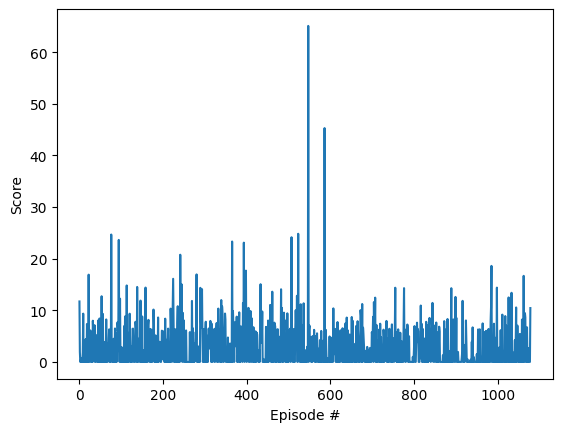

In [ ]:
import matplotlib.pyplot as plt
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
print(scores)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()